In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # Install dependency # # # # # # # # # # # # # # # # # # # # # # # # # #
# Python 3.8.3 to 3.9.0 to 3.10 ( 3.10 is experimental with ray)
# # # unQuote to install dependency
# !pip3 install matplotlib
# !pip3 install numpy

# # # unQuote to install dependency
# # # for Nvidia gpu / cpu version  # I didn't try with ROCm for AMD gpu (pytorch.org) if you want to look at it
# update nvidia driver
# download and install cuda from : https://developer.nvidia.com/cuda-11-6-1-download-archive
# install cudnn :  https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

# # # unQuote to install dependency
# # # for cpu only | the model is fairly small for cartpole for example, so it should be able to run well on cpu only
# !pip3 install torch torchvision torchaudio

# # # unQuote to install dependency
# # # Gym env for game simulation
# # install for windows Microsoft C++ Build Tools 14+ (require for Box2D lib):
# # https://visualstudio.microsoft.com/downloads/
# !pip3 install gym[all]
# !pip3 install gym[atari]
# !pip install gym[accept-rom-license]
# # or
# conda install -c conda-forge gym-all
# if you can't install Box2D, try :
# for windows: conda install -c anaconda swig
# or else try the pip instruction.

# # # Ray install
# pip install -U "ray[default]"

# #### OR #####
# # replace  " !pip3 "  by " !pip " depending on the OS
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# # # for cloud compute : 
# https://docs.ray.io/en/latest/cluster/vms/getting-started.html#vm-cluster-quick-start
# https://docs.ray.io/en/latest/train/train.html
# change ray.init() in self_play.py for remote cluster
# make a ray.init() for the forward/loss/backprob function by splitting the input(batch) to worker(remote cluster)
# and wrap model muzero_model.train() into a ray.init()



In [ ]:
# from self_play import Show_all_gym_env,Show_specific_gym_env_structure
# print all the available gym env
# Show_all_gym_env()
        
# # # show spaces of specific env
# Show_specific_gym_env_structure("CartPole-v1")

In [1]:
import gym


from monte_carlo_tree_search import *
from game import *
from replay_buffer import *
from self_play import *
from muzero_model import *


# # # unquote to print complet tensor
# torch.set_printoptions(profile="full")
# np.set_printoptions(threshold=np.inf)

c:\Users\ddery\anaconda3\envs\pentos\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # # set game environment from gym library
# # # render_mode should be set to None if you don't want rgb observation
env = gym.make("CartPole-v1", render_mode=None) 
# # # if you want want rgb observation set render_mode to "rgb_array" , "human" or the render_mode rgb of our env
# # # so for example if you want to use vision_model, you will have to change it
# env = gym.make("ALE/Asterix-v5",render_mode='human')

# # # the random seed are set to 0 for reproducibility purpose
# # #  https://pytorch.org/docs/stable/notes/randomness.html
seed = 0
np.random.seed(seed) # set the random seed of numpy
torch.manual_seed(seed) # set the random seed of pytorch
try : env.seed(seed) # set the random seed of gym env
except: pass

# # # init/set muzero model for training and inference
muzero = Muzero(model_structure = 'mlp_model', # 'vision_model' : will use rgb as observation , 'mlp_model' : will use game state as observation
                observation_space_dimensions = env.observation_space, # dimension of the observation 
                action_space_dimensions = env.action_space, # dimension of the action allow (gym box/discrete)
                state_space_dimensions= 31, # support size / encoding space (keep state smaller than hidden layer and use odd number)
                hidden_layer_dimensions = 64, # number of weight in the recursive layer of the mlp
                number_of_hidden_layer= 0, # number of recusion layer of hidden layer of the mlp
                k_hypothetical_steps= 10, # number of future step you want to be simulate during train (they are mainly support loss)
                learning_rate= 0.01,# learning rate of the optimizer
                optimizer = "adam", # optimizer "adam" or "sgd"
                lr_scheduler = None,# learning rate scheduler
                loss_type = "general", # muzero loss can be "general" or "game"
                num_of_epoch = 10000, # number of step use by lr_scheduler
                device="cpu", # hardware on which to compute : "cpu" , "cuda" (it will auto scale on multi gpu or cpu for training, not inference)
                type_format = torch.float32, # choice the dtype of the model. look at [https://pytorch.org/docs/1.8.1/amp.html#ops-that-can-autocast-to-float16]
                load = False, # function to load a save model
                use_amp = False, # use mix precision (will get more accuracy than single single precision for smaller dtype like torch.float16. amp do not support torch.float64. will turn amp to True by fault for torch.float16)
                bin_method = "uniform_bin", # "linear_bin" , "uniform_bin" : will have a regular incrementation of action or uniform sampling(pick randomly) from the bound
                bin_decomposition_number = 10, # number of action to sample from low/high bound of a gym discret box
                priority_scale=0.5) 

demonstration_buffer = DemonstrationBuffer()
# demonstration_buffer.load_back_up_buffer("config/255_hbuffer.pickle")

# # # init/set the game storage(stor each game) and dataset(create dataset) generate during training
replay_buffer = ReplayBuffer(window_size = 500, # number of game store in the buffer
                             batch_size = 128, # batch size is the number of observe game during train
                             num_unroll = muzero.k_hypothetical_steps, # number of mouve/play store inside the batched game
                             td_steps = 50, # number of step the value is select and scale on 
                             game_sampling = "priority", # 'uniform' or "priority" (will game randomly or with a priority distribution)
                             position_sampling = "priority",# 'uniform' or "priority" (will sample position in game randomly or with a priority distribution)
                             reanalyze_stack = [ReanalyseBuffer(),
                                                demonstration_buffer,
                                                MostRecentBuffer(max_buffer_size = 20),
                                                HighestRewardBuffer()],
                             reanalyse_fraction=0., # porcentage/100 of reanalyze vs new_game
                             reanalyse_fraction_mode = "chance" # "chance" or "ratio"
                             ) 

# # # init/set the monte carlos tree search parameter
mcts = Monte_carlo_tree_search(pb_c_base = 19652, 
                                pb_c_init = 1.25,
                                discount = 0.997, 
                                root_dirichlet_alpha = 0.25, 
                                root_exploration_fraction = 0.25,
                                num_simulations = 11,# number of level (length of the tree )
                                maxium_action_sample = 2,# number of node per level ( width of the tree )
                                number_of_player = 1, # will cycle linearly to each player
                                custom_loop = None) # can create a custome cycle like : "1>2>3>3" ( cycle around 2 player and to player 3 two times )

# # # ini/set the Game class which embbed the gym game class function
gameplay = Game(gym_env = env, 
                discount = mcts.discount,
                limit_of_game_play = 500, # maximum number of mouve , by default float("inf")
                observation_dimension = muzero.observation_dimension, 
                action_dimension = muzero.action_dimension,
                rgb_observation = muzero.is_RGB,
                action_map = muzero.action_dictionnary,
                priority_scale=muzero.priority_scale)


print( f"Dimension of the observation space : {muzero.observation_dimension} \
         Dimension of the action space : {muzero.action_dimension}")


# # # train model (if you choice vison model it will render the game)
epoch_pr , loss ,reward,learning_config = learning_cycle(number_of_iteration = 10000, # number of epoch(step) in  muzero should be the |total amount of number_of_iteration x number_of_training_before_self_play|
                                          number_of_self_play_before_training = 1, # number of game played record in the replay buffer before training
                                          number_of_training_before_self_play = 1, # number of epoch cpmpute by the model before selplay
                                          model_tag_number = 421, # tag number use to generate checkpoint
                                          tempererature_type = "static_temperature" , # "static_temperature" ,"linear_decrease_temperature" ,  "extreme_temperature" and "reversal_tanh_temperature"
                                          verbose = True, # if you want to print the epoch|reward|loss during train
                                          number_of_worker_selfplay = 0, # "max" will set the max amount of cpu core, 0 will make selflay run sequentially. Parallelize self-play on the number of worker
                                          muzero_model = muzero,
                                          gameplay = gameplay,
                                          monte_carlo_tree_search = mcts,
                                          replay_buffer = replay_buffer)
# if this one does work test with 10 sim 
#tag 248 start

Dimension of the observation space : 4          Dimension of the action space : 2
save model with :  16.0  reward
EPOCH 1 || selfplay reward: 16.0 || training loss: 31.2739315032959||
save model with :  25.0  reward
EPOCH 2 || selfplay reward: 25.0 || training loss: 33.25413513183594||
EPOCH 3 || selfplay reward: 12.0 || training loss: 27.447086334228516||
save model with :  34.0  reward
EPOCH 4 || selfplay reward: 34.0 || training loss: 24.873376846313477||
EPOCH 5 || selfplay reward: 24.0 || training loss: 19.76923370361328||
EPOCH 6 || selfplay reward: 13.0 || training loss: 13.313541412353516||
EPOCH 7 || selfplay reward: 29.0 || training loss: 11.012642860412598||
EPOCH 8 || selfplay reward: 12.0 || training loss: 12.83993911743164||
EPOCH 9 || selfplay reward: 10.0 || training loss: 10.225574493408203||
EPOCH 10 || selfplay reward: 25.0 || training loss: 10.745813369750977||
EPOCH 11 || selfplay reward: 10.0 || training loss: 9.927568435668945||
EPOCH 12 || selfplay reward: 12.0 

creating report at : | directory: report/ | model tag: 421 |


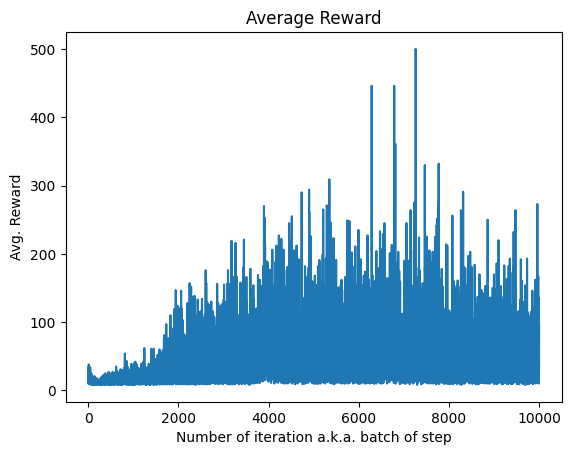

<Figure size 640x480 with 0 Axes>

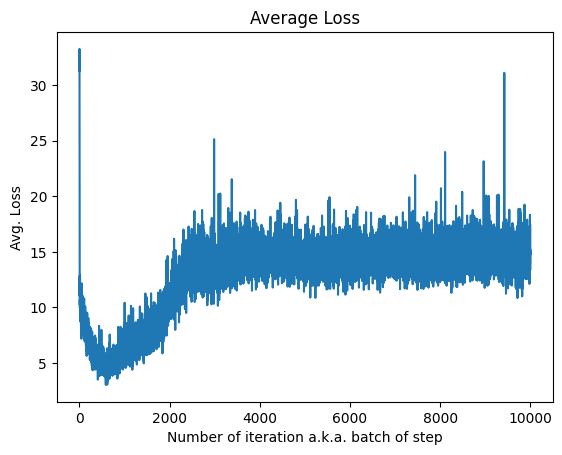

<Figure size 640x480 with 0 Axes>

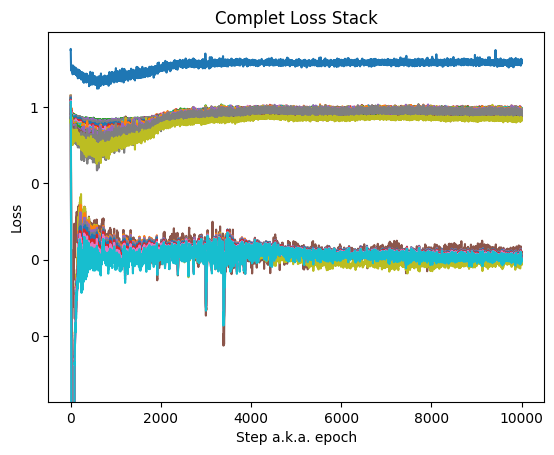

<Figure size 640x480 with 0 Axes>

In [3]:
from self_play import report, generate_config_file #change activation function and normalize obs

report( muzero, replay_buffer, epoch_pr, loss, reward, verbose = True)

generate_config_file(env,seed,muzero,replay_buffer,mcts,gameplay,learning_config)


In [ ]:
# !python muzero_cli play config/experiment_255_config.json
#or
from self_play import play_game_from_checkpoint 
import torch

play_game_from_checkpoint(game_to_play = 'CartPole-v1',
                          model_tag = 421,
                          model_device = "cuda",
                          model_type = torch.float32,
                          mcts_pb_c_base=19652 , 
                          mcts_pb_c_init=1.25, 
                          mcts_discount= 0.997, 
                          mcts_root_dirichlet_alpha=0.25, 
                          mcts_root_exploration_fraction=0.25,
                          mcts_with_or_without_dirichlet_noise = True,
                          number_of_monte_carlo_tree_search_simulation = 11,
                          maxium_action_sample = 2,# number of node per level ( width of the tree )
                          number_of_player = 1, 
                          custom_loop = None,
                          gameplay_discount = 0.997,
                          temperature = 0,
                          game_iter = 500,
                          slow_mo_in_second = 0.0,
                          render = True,
                          verbose = True)

In [ ]:
# !python muzero_cli benchmark config/experiment_255_config.json
#or
# benchmark 
from self_play import play_game_from_checkpoint,benchmark
import torch

number_of_trial = 100
cache_t,cache_r,cache_a,cache_p = [],[],[],[]
for _ in range(number_of_trial):
    tag , reward , action, policy = play_game_from_checkpoint(game_to_play = 'CartPole-v1',
                                                                model_tag = 421,
                                                                model_device = "cuda",
                                                                model_type = torch.float32,    
                                                                mcts_pb_c_base=19652 , 
                                                                mcts_pb_c_init=1.25, 
                                                                mcts_discount= 0.997, 
                                                                mcts_root_dirichlet_alpha=0.25, 
                                                                mcts_root_exploration_fraction=0.25,
                                                                mcts_with_or_without_dirichlet_noise = True,
                                                                number_of_monte_carlo_tree_search_simulation = 11, 
                                                                maxium_action_sample = 2,# number of node per level ( width of the tree )
                                                                number_of_player = 1, 
                                                                custom_loop = None, 
                                                                gameplay_discount = 0.997,  
                                                                temperature = 0,
                                                                game_iter = 500,
                                                                slow_mo_in_second = 0,
                                                                render = False,
                                                                verbose = False,
                                                                benchmark = True) # Need benchmark True to return output
    #could do it in one list or even wrap the play_game with benchmark but it reduce clarity
    cache_t.append(tag)
    cache_r.append(reward)
    cache_a.append(action)
    cache_p.append(policy)


benchmark(cache_t,
          cache_r,
          cache_a,
          cache_p,
          folder = "report",
          verbose = True)

#on cartpole the reward is fix to 1, so it follow the number of mouve.